In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Functions import *

In [94]:
c = 3*1e8
ng_1550     = 1.595643967049753
freq_1550   = c/(1550*1e-9)


In [95]:
def Control_angle_range_0_2_2pi(angle):
    mask_less = np.where(angle < 0)
    mask_more = np.where(angle > 2*np.pi)
    angle_copy = np.copy(angle)
    angle_copy[mask_less] = angle[mask_less] + (np.astype(-angle[mask_less] / (2*np.pi),int)+1) *2*np.pi
    angle_copy[mask_more] = angle[mask_more] - (np.astype(angle[mask_more] / (2*np.pi),int)) *2*np.pi
    return angle_copy


In [96]:
def Control_angle_range_mpi_2_pi(angle):
    mask_less = np.where(angle < - np.pi)
    mask_more = np.where(angle > np.pi)
    angle_copy = np.copy(angle)
    angle_copy[mask_less] = angle[mask_less] + (np.astype((-angle[mask_less]+np.pi)/ (2*np.pi),int)) *2*np.pi
    angle_copy[mask_more] = angle[mask_more] - (np.astype((angle[mask_more]+np.pi) / (2*np.pi),int)) *2*np.pi
    return angle_copy


In [97]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp


In [98]:
def Eigenvalue_arg(freq,g,Lco,LAS,LAL,LBS,LBL,include_theory=False):
    LA      = 2*(LAS + LAL + Lco)     # unit: m
    LB      = 2*(LBS + LBL + Lco)     # unit: m
    beta    = ng_1550/c * freq * 2*np.pi         # unit: /m
    Sum     = np.exp(2* 1j * beta * LAS) + np.exp(2* 1j * beta * LBL)
    Diff    = np.exp(2* 1j * beta * LAS) - np.exp(2* 1j * beta * LBL)
    # print(beta)
    # print("Sum = ", np.angle(Sum)[:10])
    # print("Sum_theory = ", np.angle(np.exp(1j *2 * beta[:10] * LAS)))
    # print("Diff = ", Diff)
    # print(g)

    DL_uco  = (LBL-LAS)
    DL_tot  = (LB-LA)/2
    DL      = DL_uco - DL_tot
    F       = Sum * np.cos(2 * g * Lco) * np.cos(beta * DL) - 1j * Diff * np.sin(beta * DL)

    Ang_theory  = np.arccos(np.cos(2 * g * Lco) * np.cos(beta * DL))
    Ang_theory_p= Control_angle_range_mpi_2_pi(Ang_theory)
    Ang_theory_m= Control_angle_range_mpi_2_pi(-Ang_theory)
    # offset      = np.pi/DL
    # Ang_theory_p_offset= np.arccos(np.cos(2 * g * Lco) * np.cos(beta * DL + offset))
    # Ang_theory_m_offset= np.arccos(np.cos(2 * g * Lco) * np.cos(beta * DL - offset))

    Ang_offset  = - np.angle(np.exp(1j * beta * (LAS+LBL)))
    Ang_p       = Control_angle_range_mpi_2_pi(np.angle(0.5*(F + 1j * np.sqrt((Sum**2-Diff**2) - F**2))) + Ang_offset)
    Ang_m       = Control_angle_range_mpi_2_pi(np.angle(0.5*(F - 1j * np.sqrt((Sum**2-Diff**2) - F**2))) + Ang_offset)

    flip_mask   = np.where(Ang_p < Ang_m)
    Ang_pre                 = np.c_[Ang_p, Ang_m]
    Ang_pre[flip_mask]      = np.flip(Ang_pre[flip_mask],axis=1)
    if include_theory:
        Ang_pre             = np.c_[Ang_pre,Ang_theory_p,Ang_theory_m]
    return Ang_pre

In [99]:
# Load kappa under different wavls of two coupled WGs width 2.8um
def Load_kappa_data():
    c = 3*10**8
    Kappa_arr = []
    with open ("./results/straight_WG_Kappa.txt",'r') as f:
        read_data = f.readlines()
        for line in read_data[1:]:
            line_strip = line.strip()
            wavl = float(line_strip.split(",")[0])
            freq = c/wavl * 1e9
            K_12 = str2complex(line_strip.split(",")[1])
            K_21 = str2complex(line_strip.split(",")[2])
            Kappa = (K_12+K_21)/2
            Kappa = np.real(Kappa)
            Kappa_arr.append([freq,Kappa])
        Kappa_arr = np.array(Kappa_arr)
    return Kappa_arr

In [100]:
# g : dict of coupling strength
def Reson_freq_2D(m,D_ave,g,L,epsilon):
    return D_ave/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *m))

def FSR_func_2D(m,D_ave,g,L,epsilon):
    return epsilon * D_ave/(2*np.pi)* np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**0.5

def Dispersion_2D(m,D_ave,g,L,epsilon):
    return D_ave *(2*np.pi)* epsilon**2 *np.cos(g*L) *np.sin(g*L)**2 * np.cos(2*np.pi*epsilon*m) / \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**1.5

def Reson_freq_3D(m,D_ave,g,Lco,LAS,LAL,LBS,LBL):
    freq = freq_1550 + m * D_ave/(2*np.pi)
    Eigenvalue_Arg  = Eigenvalue_arg(freq,g,Lco,LAS,LAL,LBS,LBL)
    return D_ave/(2*np.pi) * Eigenvalue_Arg

def FSR_func_3D(m,reson_freq):
    FSR = First_derivative_central_diff(reson_freq,m)
    return FSR

def Dispersion_3D(m,reson_freq):
    FSR = First_derivative_central_diff(reson_freq,m)
    return First_derivative_central_diff(FSR,m[1:-1])

In [101]:
def Mode_nonconserved_coupling(Max_M_idx,M,
                               plot_coupled_curves=True,
                               coupled_data_arr=[],coupled_data_label_arr=[],
                               title = "Mode number non-conservation coupling",
                               num_of_pts=100,ylim=()):
    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Resonator1 $\omega = \omega_0$+$(D_1-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator1 $\omega$ = $\omega_0$+$(D_1-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D1 * (m_arr - M0) - m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Resonator2 $\omega = \omega_0$+$(D_2-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator2 $\omega$ = $\omega_0$+$(D_2-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D2 * (m_arr - M0) -  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")
    Y_data = Y_data - D_ave * (m_arr - M0)

    if plot_coupled_curves:
        Y_data = np.c_[Y_data,coupled_data_arr]
        Y_legends = Y_legends + coupled_data_label_arr

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M

    data_arr = (np.c_[m_arr,Y_data/1e9/(2*np.pi)],)

    linestyle_name_list = ["dashed","dotted"]*3
    linestyle_list      = ["-"]
    for i in range(Max_M_idx-1):
        for j in range(2):
            linestyle_list.append(linestyle_name_list[i])
    linestyle_list = linestyle_list + linestyle_list
    linestyle_list = linestyle_list + ["-"]*30
    colors_list = ['tab:blue']*(Max_M_idx*2-1)+ ['tab:red']*(Max_M_idx*2-1)\
                    +['tab:orange']*2+['tab:green']*2+['cyan']*2+['deepskyblue']*2+['black']*30
    param_dict = {  "Y_legends"       : Y_legends,
                    "X_label"         : 'mode number m',
                    "Y_label"         : r"Frequency $\omega$/(2$\pi$) (GHz)",
                    "xticks"          : xticks,
                    "xtickslabel"     : xtickslabels,
                    "title"           : title,
                    "marker_list"     : [""]*30,
                    "linestyle_list"  : linestyle_list,
                    "colors_list"     : colors_list,
                    "xlim"            : (-Max_M_idx*M,Max_M_idx*M),
                    "ylim"            : ylim,
                    "bbox_legend"     : (1.05,0.8)}

    Plot_curve(data_arr,**param_dict)

In [102]:
Max_M_idx   = 5
num_of_pts  = 1000

In [103]:
# unit: m
LAS = 1.6   *1e-3
LAL = 1.605  *1e-3
LBS = 1.6   *1.005    *1e-3
LBL = 1.605  *1.005    *1e-3
g0  = 694
Lco = 0.8 / g0

In [104]:
L1      = (Lco + LAS + LAL)*2
L2      = (Lco + LBS + LBL)*2
D1      = c/(ng_1550 * L1) *2* np.pi
D2      = c/(ng_1550 * L2) *2* np.pi
D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
epsilon = (L2-L1)/(L1+L2)
FSR     = (D1-D2)/(2*epsilon)
M       = 1/(2*epsilon)
FSR/1e9/(2*np.pi)
D_ave/(2*np.pi*1e9)
print("M=",M)
print("D_ave/2pi=",D_ave/(2*np.pi*1e9))
print("epsilon=",epsilon)

M= 272.4337130834043
D_ave/2pi= 21.532595237724195
epsilon= 0.0018353088328937003


In [105]:
Kappa_arr       = Load_kappa_data()
Kappa_arr       = np.flip(Kappa_arr,axis=0)
freq_arr        = Kappa_arr[:,0]
freq_arr

array([1.85185185e+14, 1.86335404e+14, 1.87500000e+14, 1.88679245e+14,
       1.89873418e+14, 1.91082803e+14, 1.92307692e+14, 1.93548387e+14,
       1.94805195e+14, 1.96078431e+14, 1.97368421e+14, 1.98675497e+14,
       2.00000000e+14, 2.01342282e+14, 2.02702703e+14])

In [106]:
m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)
g_arr_intp      = Interpolation(freq_arr,Kappa_arr[:,1],freq_arr_intp)
data_arr        = np.c_[m_arr_intp,freq_arr_intp,g_arr_intp]

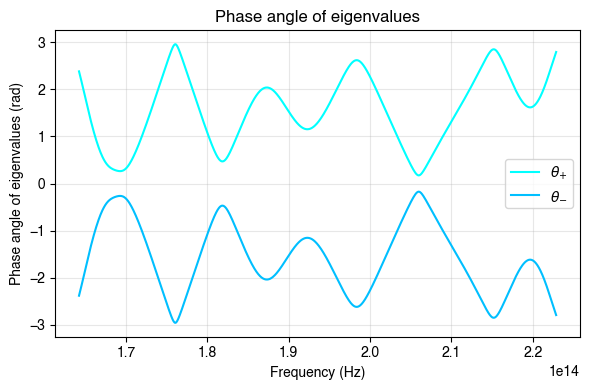

In [107]:
Eigenvalue_Arg = Eigenvalue_arg(freq_arr_intp,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
data_arr        = (np.c_[freq_arr_intp,Eigenvalue_Arg],)
data_label_arr  = [r"$\theta_{+}$",r"$\theta_{-}$",r"$\theta_{theory,+}$",r"$\theta_{theory,+}$"]*3
linestyle_list  = ["-","-","--","--"]*3
colors_list     = ['cyan']+['deepskyblue']+['orange']+['red']*10
param_dict      = {"Y_legends": data_label_arr,
                "X_label"     : r'Frequency (Hz)',
                "Y_label"     : r"Phase angle of eigenvalues (rad)",
                "title"       : r"Phase angle of eigenvalues",
                "figsize"     : (6,4),
                "marker_list" : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list" : colors_list,
                "AD_region_color"  : False}
Plot_curve(data_arr,**param_dict)

In [108]:
# g = 700*1e-3
# ratio_arr = np.arange(1.00001,1.01001,0.0005)
# # ratio_arr = np.ones(1)*1.00001
# for ratio in ratio_arr:
#     Lco = 0.7
#     LAS = 1.6
#     LAL = 1.6
#     LBS = 1.6 * ratio
#     LBL = 1.6 * ratio
#     Eigenvalue_Arg = Eigenvalue_arg(freq_arr,g,Lco,LAS,LAL,LBS,LBL)

#     data_arr        = (np.c_[freq_arr,Eigenvalue_Arg],)
#     data_label_arr  = [r"$\theta_{+}$",r"$\theta_{-}$",r"$\theta_{theory,+}$",r"$\theta_{theory,+}$"]*3
#     linestyle_list  = ["-","-","--","--"]*3
#     colors_list     = ['cyan']+['deepskyblue']+['orange']+['red']*10
#     param_dict      = {"Y_legends": data_label_arr,
#                     "X_label"     : r'Frequency (Hz)',
#                     "Y_label"     : r"Phase angle of eigenvalues (rad)",
#                     "title"       : r"Phase angle of eigenvalues"+str(ratio),
#                     "figsize"     : (6,4),
#                     "marker_list" : [""]*15,
#                     "linestyle_list": linestyle_list,
#                     "colors_list" : colors_list,
#                     "AD_region_color"  : False}
#     Plot_curve(data_arr,**param_dict)


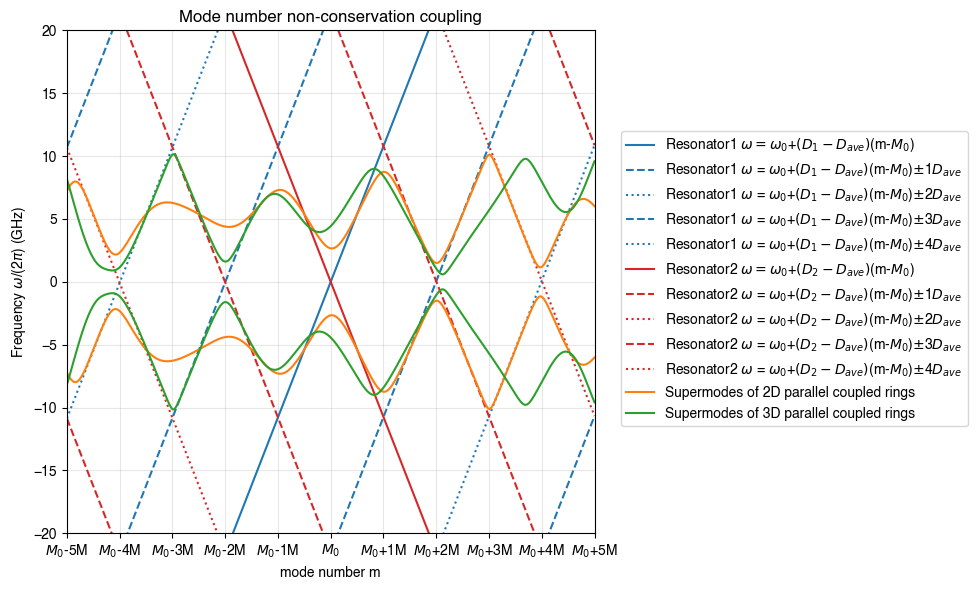

In [109]:
Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,Lco,epsilon)
Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,Lco,epsilon)
Y_3D        = Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)

data_arr = np.c_[Y_p_2D,Y_m_2D,Y_3D]
data_label_arr = ["","Supermodes of 2D parallel coupled rings",
                  "","Supermodes of 3D parallel coupled rings",
                  "","3D theory ?"]*3

Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           num_of_pts=num_of_pts,ylim=(-20,20))

In [110]:
# Dispersion of isolated resonator
D_iso   = -668                                # unit: ps/nm/km
n_g     = 1.59367
beta_2  = -1550**2/(2*np.pi*c) * D_iso *1e-9  # unit: ps^2/nm
D_2     = -c* (D_ave*1e-12)**2* beta_2 / n_g  # unit: 2pi * GHz
D_2o    = D_2*1e9                             # unit: Hz
D_2o    = -284 *1e3 * 2*np.pi
D_2o

-1784424.6272390024

In [111]:
D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_intp,Lco,epsilon)[2:-2]
D_3D        = Dispersion_3D(m_arr_intp,Y_3D[:,1])
# FSR_3D      = FSR_func_3D(m_arr_intp,Y_3D[:,1])

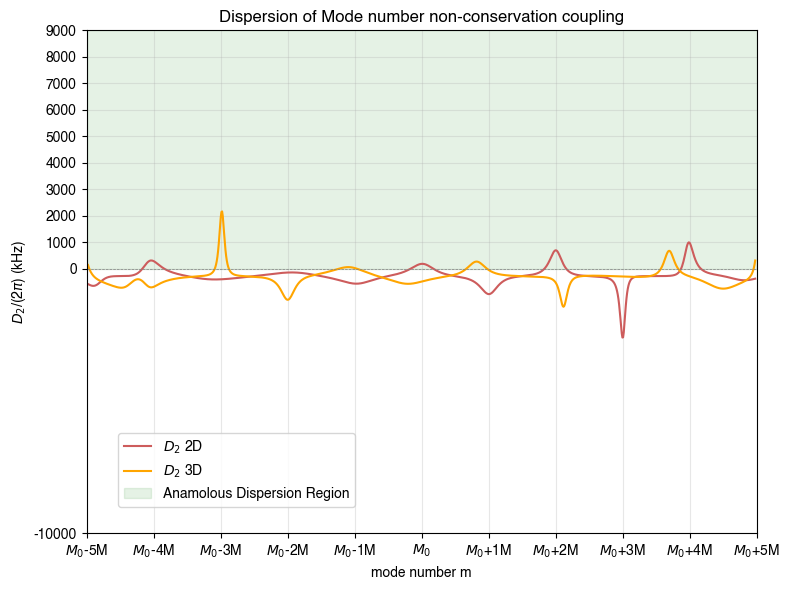

In [112]:
data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)
# data_arr        = np.c_[FSR_3D]
# data_arr        = (np.c_[m_arr_intp[1:-1] ,data_arr/1e3/(2*np.pi)],)

data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D"]*3
color_list      = ['indianred']+['Orange']+['tab:blue']+['tab:green']*2+['black']*10
linestyle_list  = ["-"]*10

xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
                for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
yticks       = ticks_arr(data_arr)
param_dict   = {"Y_legends"     : data_label_arr,
                "X_label"       :'mode number m',
                "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
                "title"         : "Dispersion of Mode number non-conservation coupling",
                "figsize"       : (8,6),
                "marker_list"   : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list"   : color_list,
                "xticks"        : xticks,
                "xtickslabel"   : xtickslabels,
                "yticks"        : yticks,
                "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
                "ylim"          : (-10000,9000),
                "AD_region_color"    : True,
                "bbox_legend"   :(0.4,0.2)}
Plot_curve(data_arr,**param_dict)



In [113]:
np.linspace(0.1,0.9,9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [114]:
np.linspace(0.01,0.51,11)

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51])

/Users/harryxwh2003/VScode/Undergrad Thesis/CoupledRings/Functions.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=param_dict["figsize"])


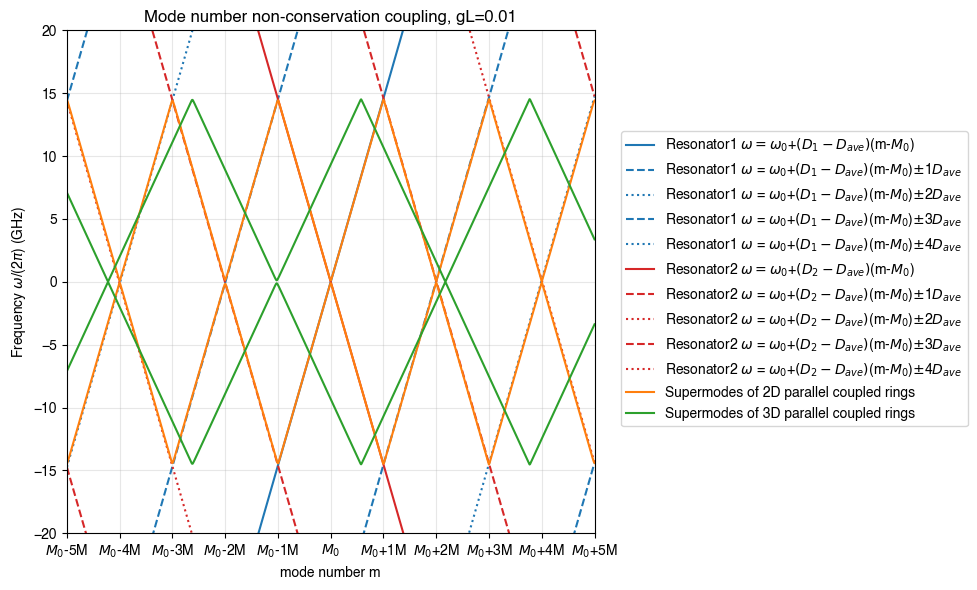

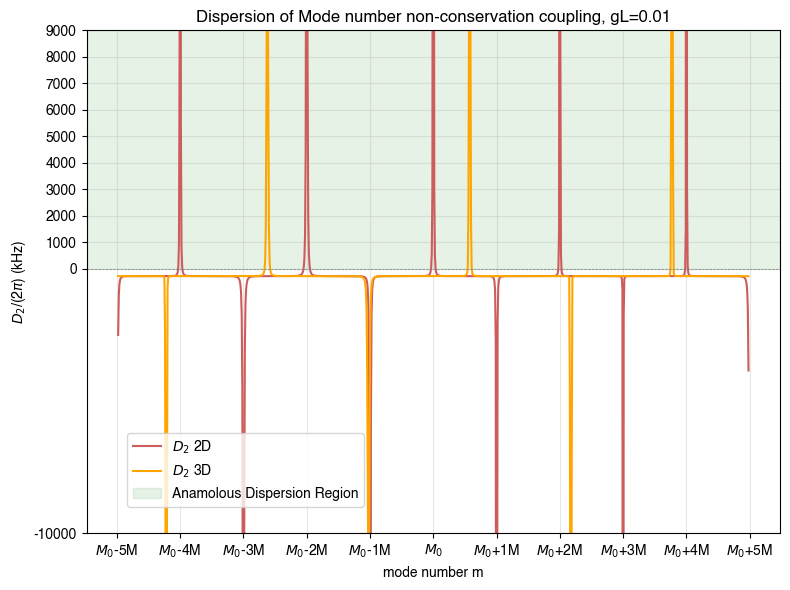

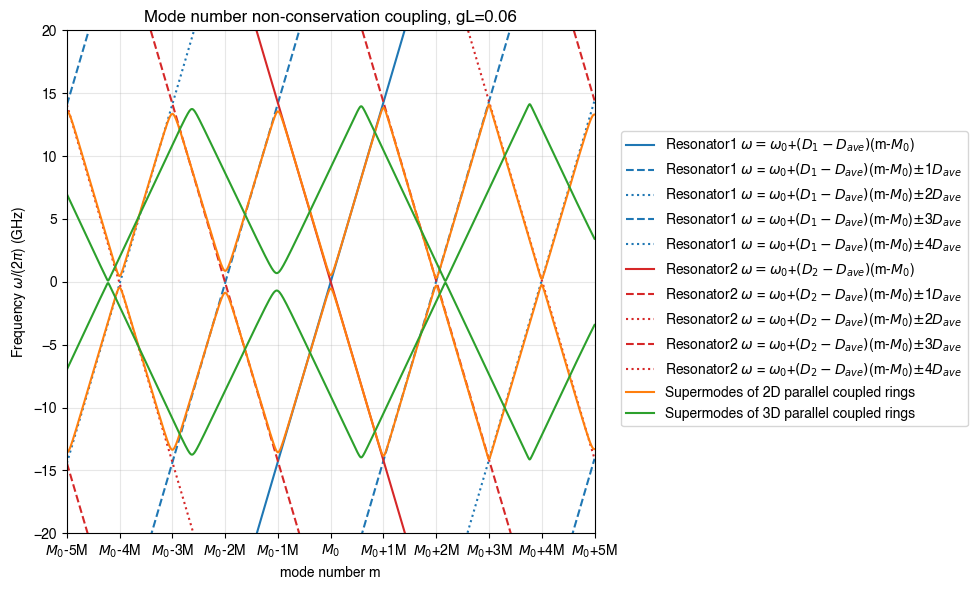

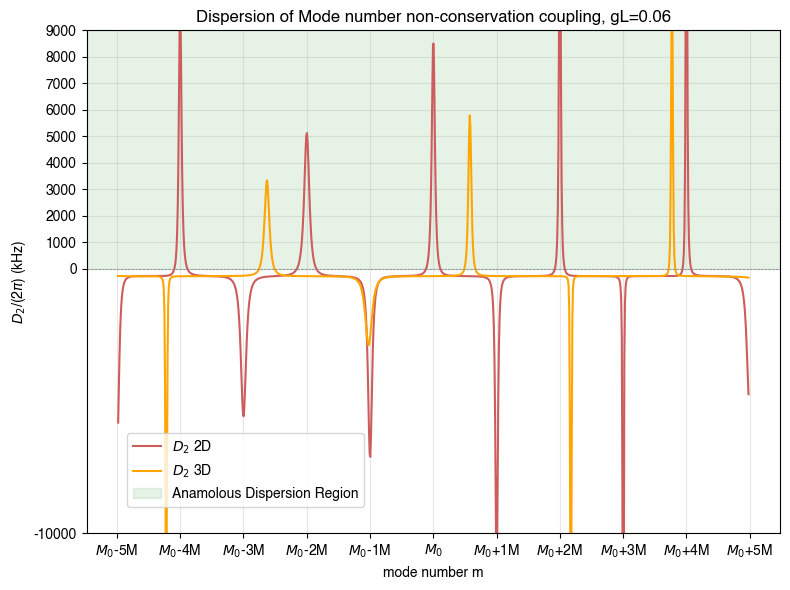

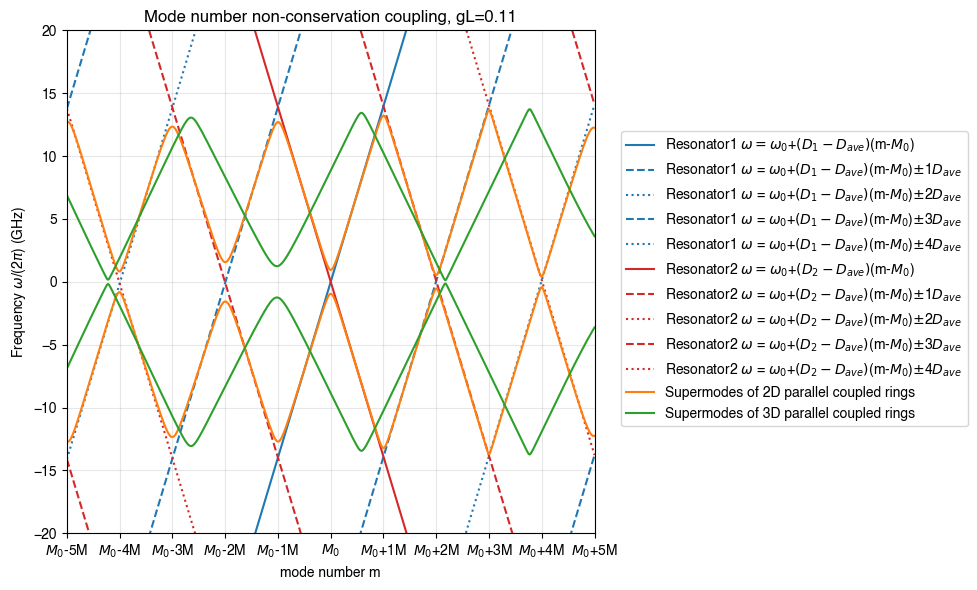

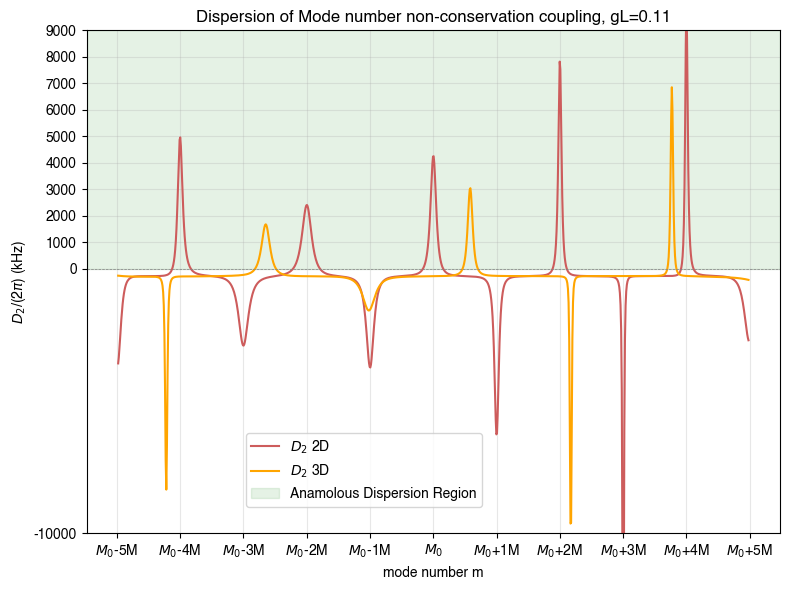

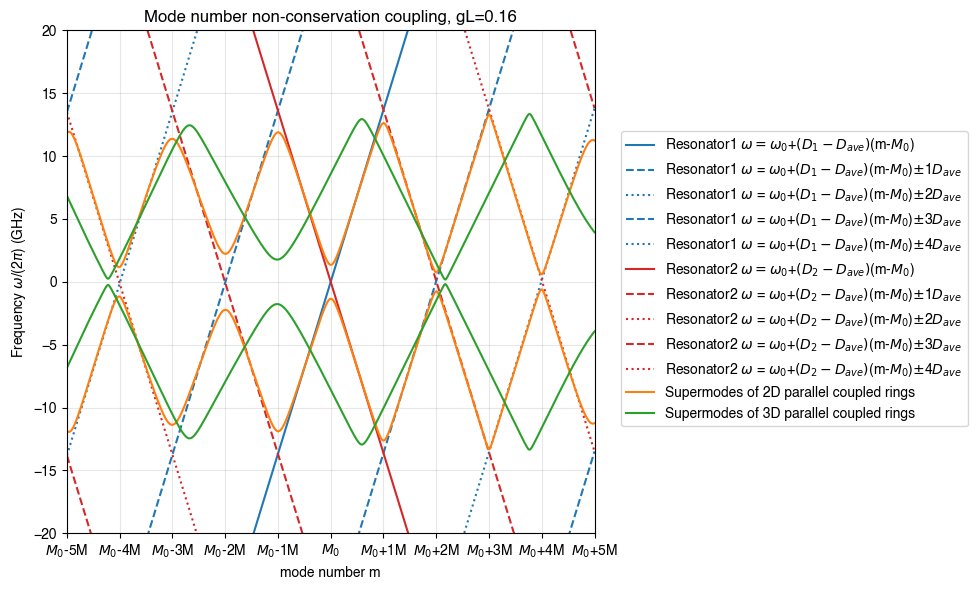

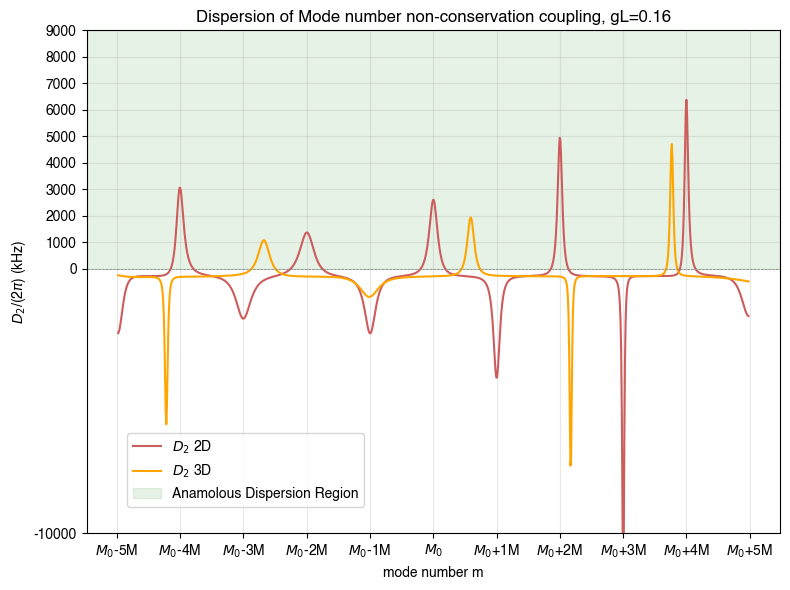

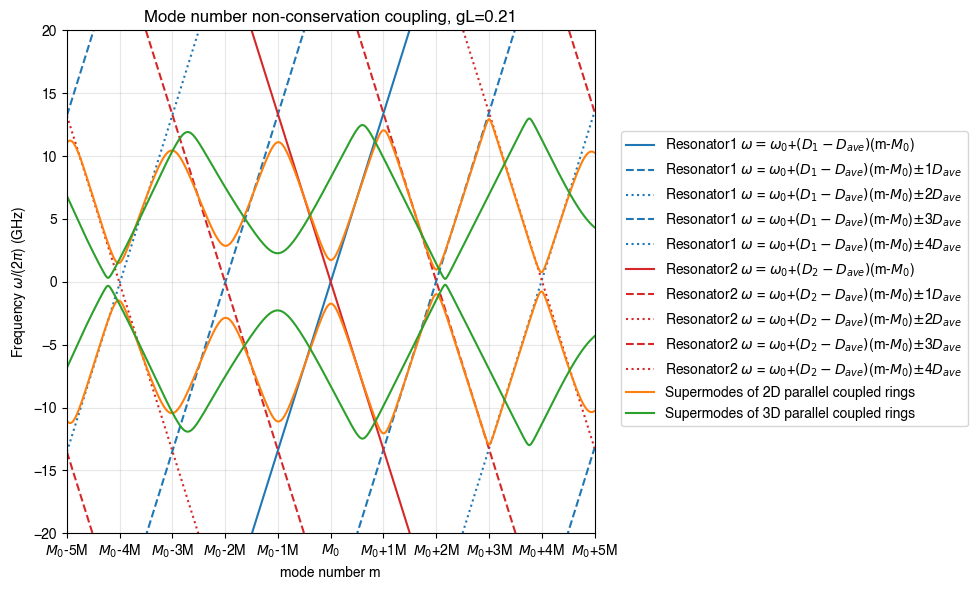

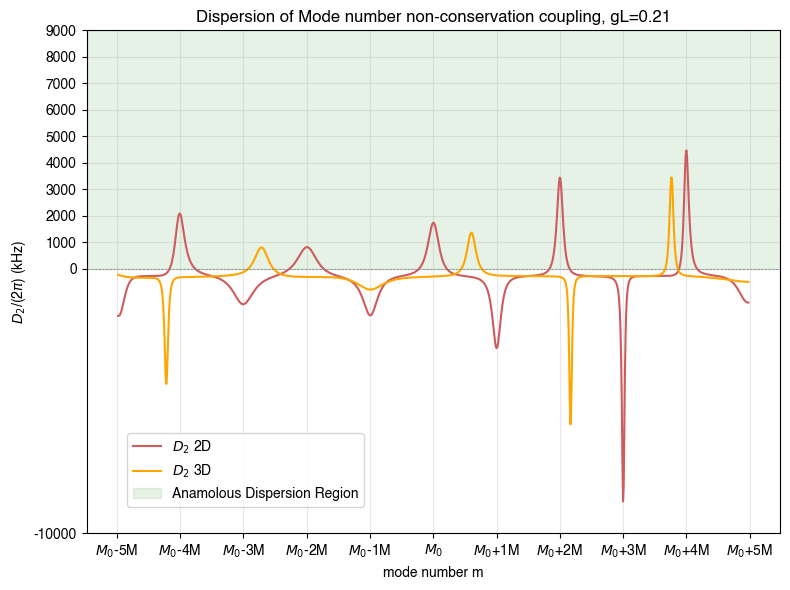

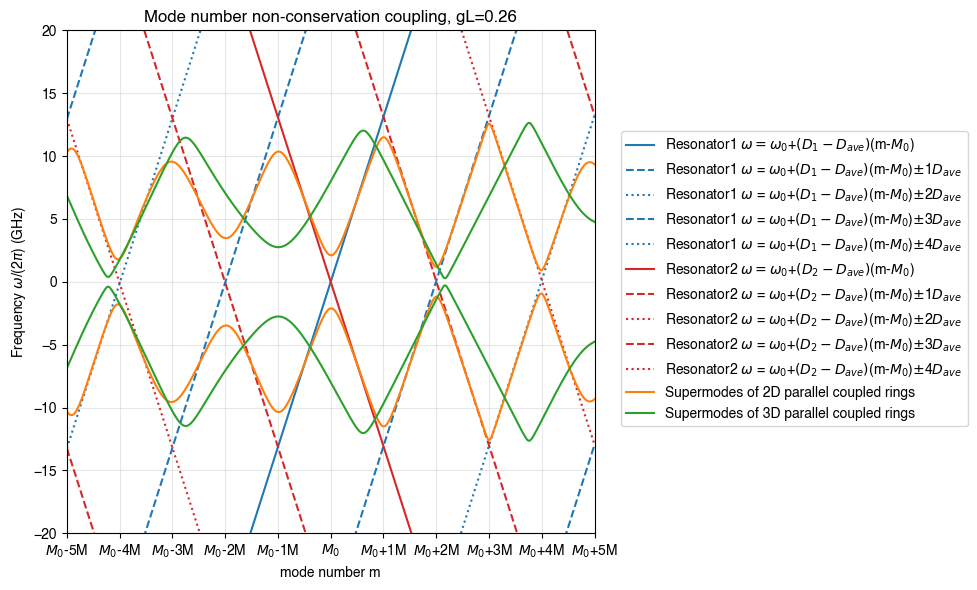

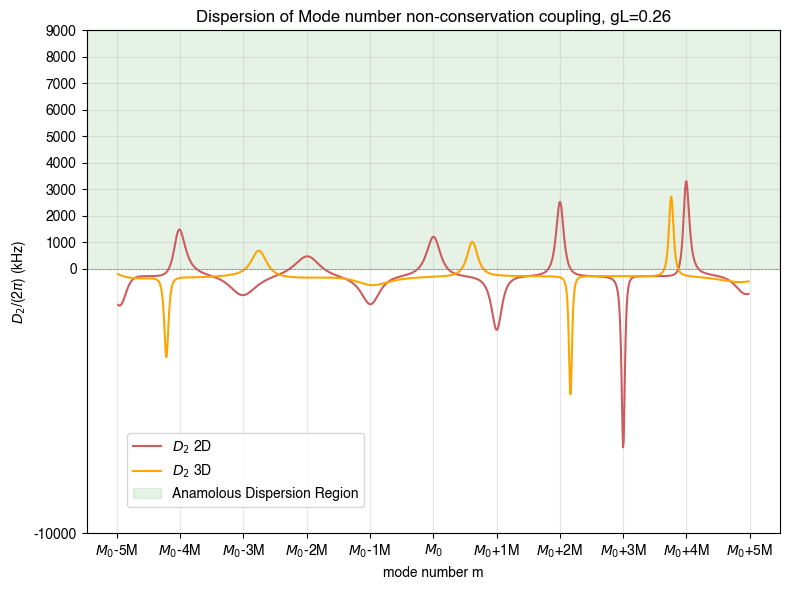

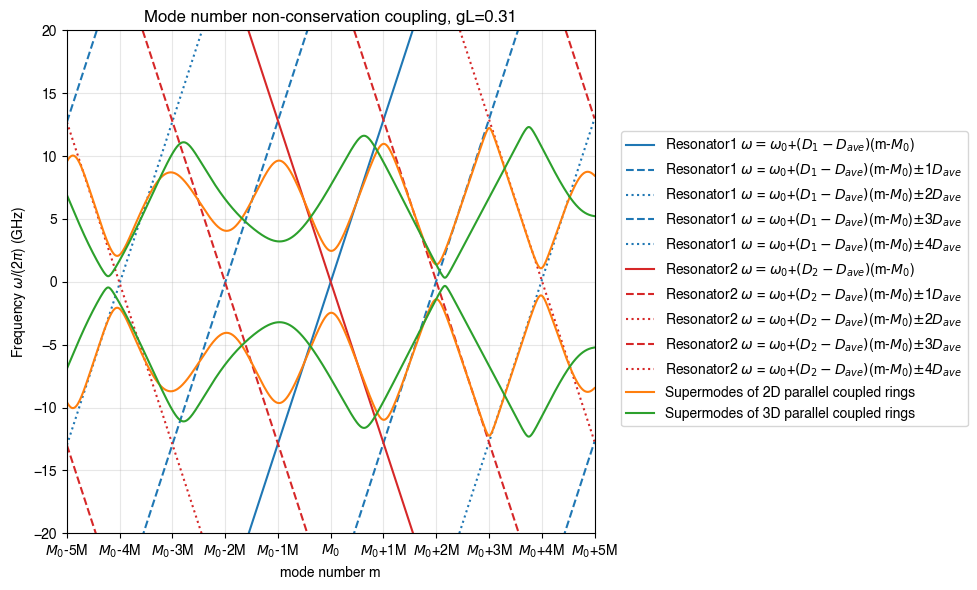

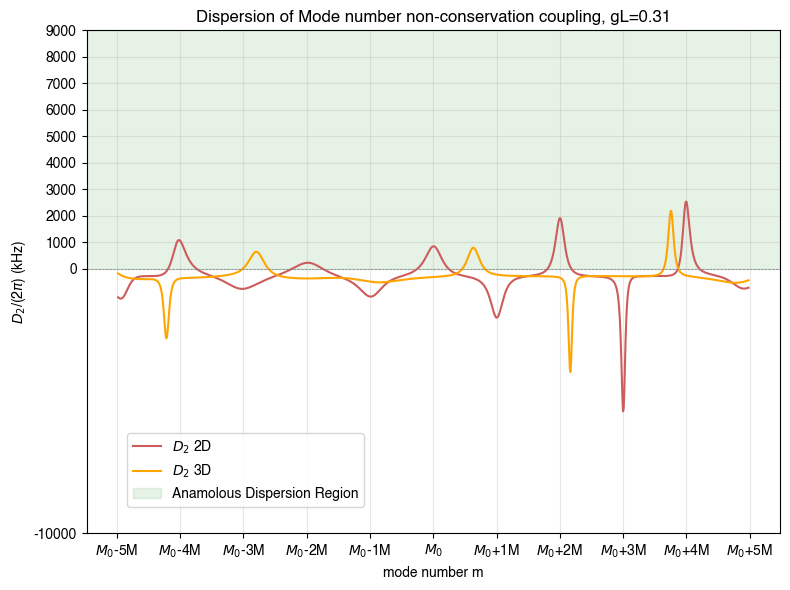

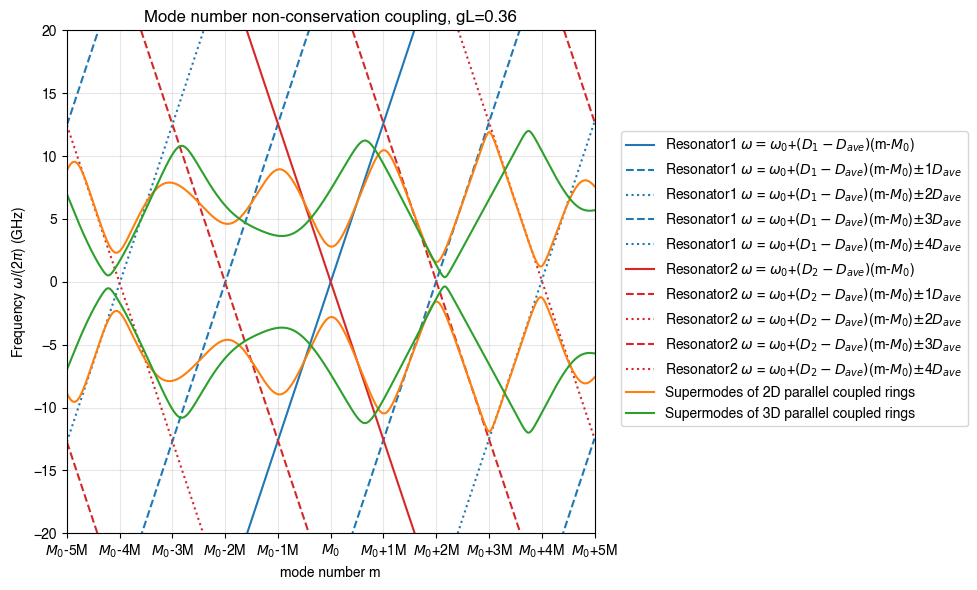

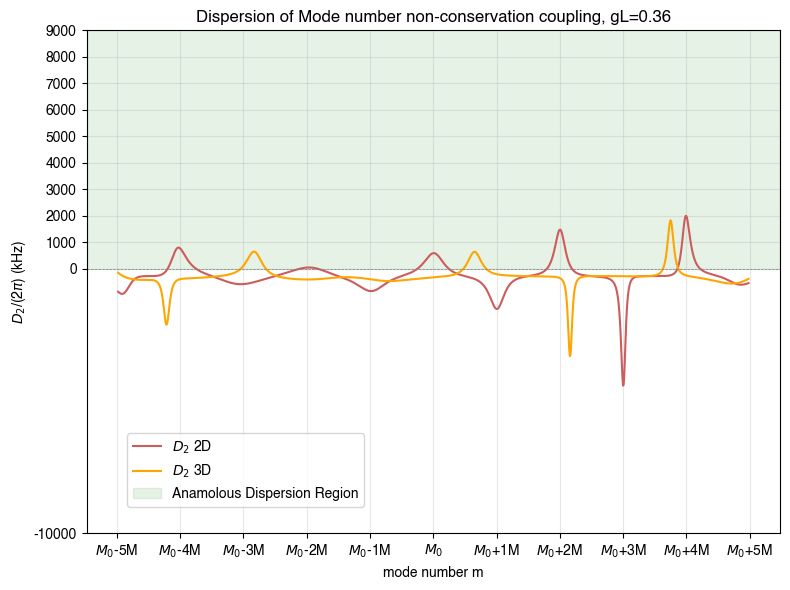

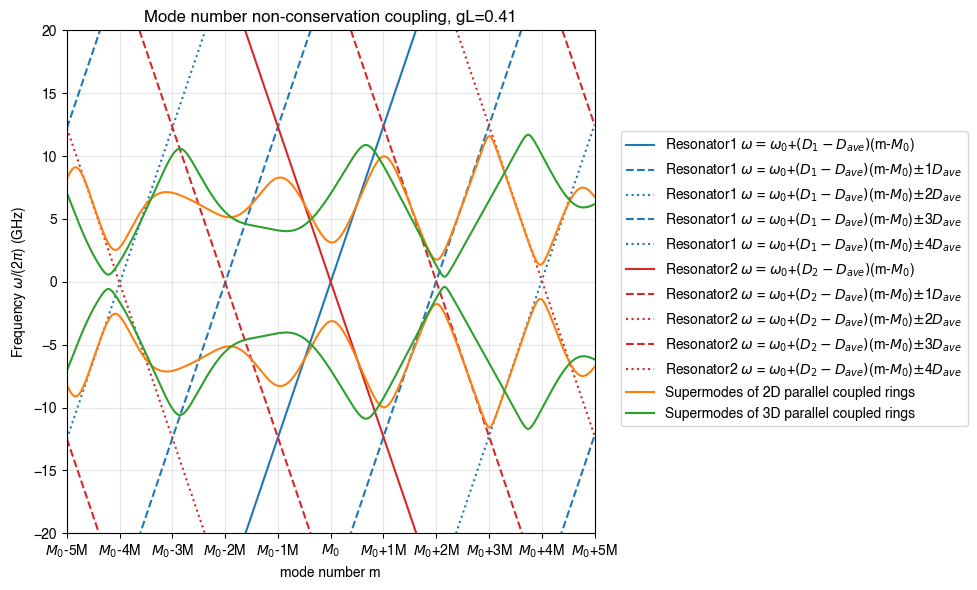

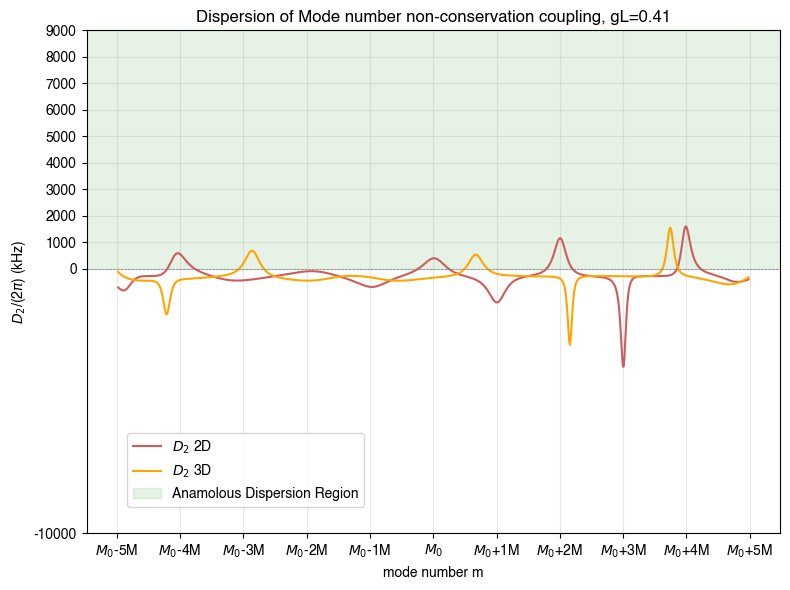

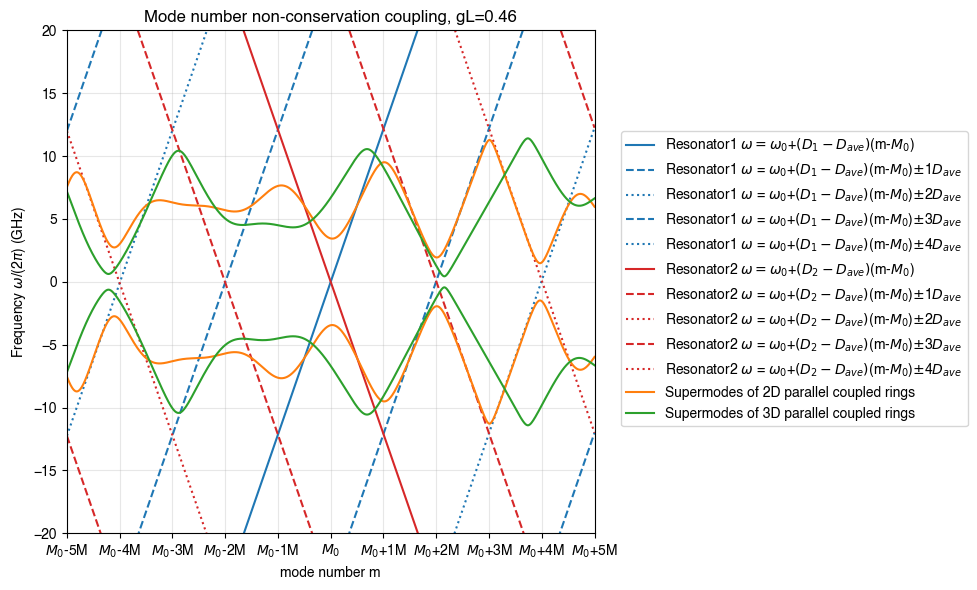

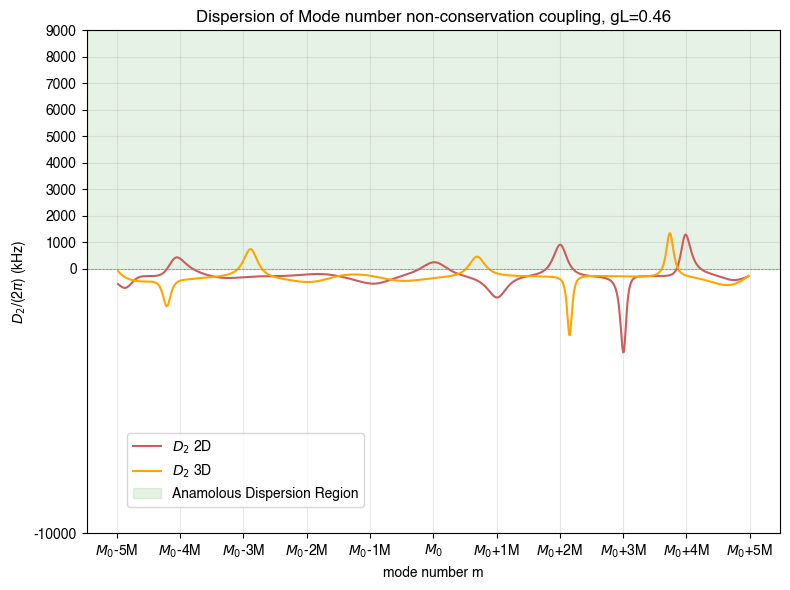

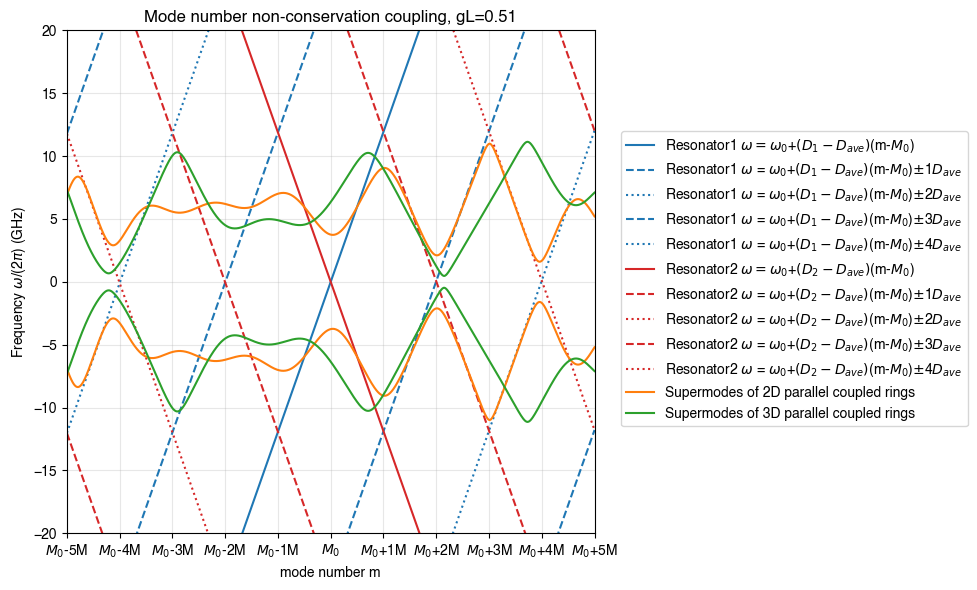

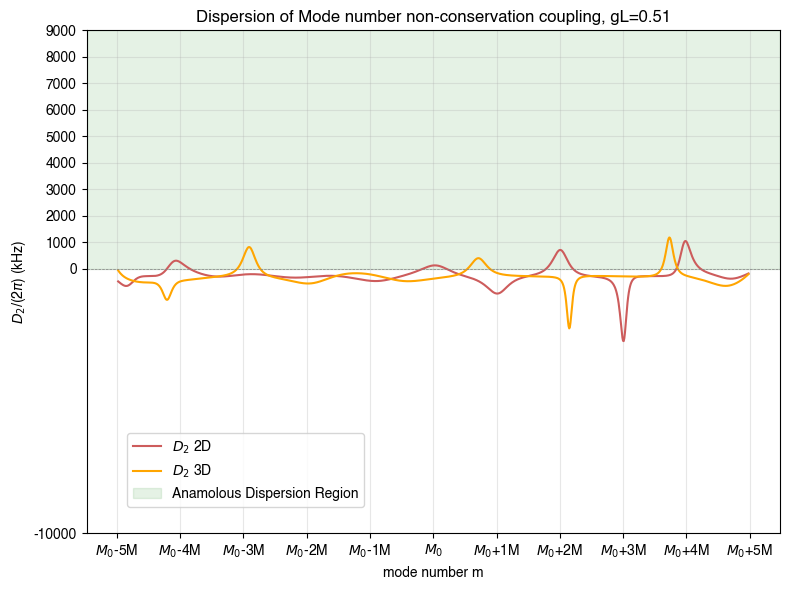

In [115]:
gL_arr = np.linspace(0.01,0.51,11)
for gL in gL_arr:
    Lco = gL / g0

    L1      = (Lco + LAS + LAL)*2
    L2      = (Lco + LBS + LBL)*2
    D1      = c/(ng_1550 * L1) *2* np.pi
    D2      = c/(ng_1550 * L2) *2* np.pi
    D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
    epsilon = (L2-L1)/(L1+L2)
    FSR     = (D1-D2)/(2*epsilon)
    M       = 1/(2*epsilon)

    m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
    freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)

    Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)
    Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)
    Y_3D        = Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)

    data_arr = np.c_[Y_p_2D,Y_m_2D,Y_3D]
    data_label_arr = ["","Supermodes of 2D parallel coupled rings",
                    "","Supermodes of 3D parallel coupled rings",
                    "","3D theory ?"]*3

    Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                            coupled_data_arr=data_arr,
                            coupled_data_label_arr=data_label_arr,
                            title ="Mode number non-conservation coupling, gL={:.2f}".format(gL),
                            num_of_pts=num_of_pts,ylim=(-20,20))

    D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
    D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)[2:-2]
    D_3D        = Dispersion_3D(m_arr_intp,Y_3D[:,1])

    data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
    data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)

    data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D"]*3
    color_list      = ['indianred']+['Orange']+['tab:blue']+['tab:green']*2+['black']*10
    linestyle_list  = ["-"]*10

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
                    for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
    yticks       = ticks_arr(data_arr)
    param_dict   = {"Y_legends"     : data_label_arr,
                    "X_label"       :'mode number m',
                    "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
                    "title"         : "Dispersion of Mode number non-conservation coupling, gL={:.2f}".format(gL),
                    "figsize"       : (8,6),
                    "marker_list"   : [""]*15,
                    "linestyle_list": linestyle_list,
                    "colors_list"   : color_list,
                    "xticks"        : xticks,
                    "xtickslabel"   : xtickslabels,
                    "yticks"        : yticks,
                    # "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
                    "ylim"          : (-10000,9000),
                    "AD_region_color"    : True,
                    "bbox_legend"   :(0.4,0.2)}
    Plot_curve(data_arr,**param_dict)

